# 0. Imports packages, modules and functions

## 0.1. Packages and modules

In [1]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt

from IPython.display            import Image
from IPython.display            import HTML
from scipy                      import stats
from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek
from scikitplot.metrics         import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve
from sklearn                    import cluster
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection    import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection    import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing      import RobustScaler, MinMaxScaler
from sklearn.preprocessing      import OneHotEncoder
from xgboost                    import XGBClassifier
from yellowbrick.classifier     import ROCAUC, ClassificationReport, ConfusionMatrix, ClassPredictionError, PrecisionRecallCurve, DiscriminationThreshold

import datetime
import inflection
import math
import pickle
import random
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

/home/pedro/.pyenv/versions/churnPrediction/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.2. Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}


def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

In [3]:
def plot_lift(ax, ys, models, step):
    x = np.arange(step, step + 1, step)

    ax.plot(x, np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.plot(x, y, '-', color=color, linewidth=3, markersize=5, label=model)
    ax.set_xlabel('Proportion of Sample')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    ticks = np.arange(0, 1.1, .1)
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.legend(loc='best')
        
    ticks = np.arange(0.1, 1.1, .1)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0.1, 1.)
    ymax = np.ceil(max(max(ys)))
    ticks = np.arange(0, ymax + 1, 1)
    ax.set_yticks(ticks=ticks, minor=False)
    ticks = np.arange(0.5, ymax, .5)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_ylim(0, ymax + .5)
    
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.1)
    
    return ax
    
def plot_rates(ax, ys, models, step):
    x = np.arange(0, 1+step, step)
    ax.plot(x, churn_ratio*np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.bar(x[:-1], y, width=step, align='edge', edgecolor=color, fill=False, label=model, linewidth=2)
    ax.set_title('Churn Rate x Model Threshold')
    ax.set_xticks(x)
    ax.set_xlabel('Predicted Probability of Churn')
    ax.set_ylabel('True Churn Rate')
    ax.legend(loc='upper left')    

    ticks = np.arange(0., 1.2, .2)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    
    return ax

def plot_cum_gain(ax, gains, models, step=0.1):
    ax.plot([0, churn_ratio, 1], [0, 1, 1], 'r--', linewidth=2, label='Ideal Classifier')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

    for gain, model, color in zip(gains, models, colors):
        ax.plot(np.arange(0, 1. + step, step), gain, linewidth=2, color=color, label=model)

    ax.set_title(f'Cumulative Gains')
    ax.set_xlabel(f'Proportion of Sample')
    ax.set_ylabel('Proportion of Churning Clients')
    ax.legend(loc='lower right')

    ticks = np.arange(0., 1.2, .2)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0, 1.)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)

    return ax

def get_lift_gain(y, y_pred, step=0.1, model='Model', plot=False):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=False, inplace=True)

    x_val = np.arange(step, step + 1, step)
    num_ones = aux_lift['true'].sum()
    N = len(aux_lift)
    ratio_ones = num_ones / N

    lifts = []
    gains = [0]
    for x in x_val:
        num_data = int(np.ceil(x * N)) 
        data_here = aux_lift.iloc[:num_data, :]
        num_ones_here = data_here['true'].sum()
        ratio_ones_here = num_ones_here / num_data
        gains.append(num_ones_here / num_ones)
        lifts.append(ratio_ones_here / ratio_ones)
           
    if plot:
        plot_lift(step, [lifts], [model])
    return lifts, gains

def get_rate(y, y_pred, step=0.1):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=True, inplace=True)

    x_val = np.arange(0, 1, step)
    y_val = []
    for x in x_val:
        xlow = int(np.ceil(x * len(aux_lift))) 
        xhigh = int(np.ceil((x+step) * len(aux_lift))) 
        data_here = aux_lift.iloc[xlow:xhigh, :]
        ratio_ones_here = data_here['true'].sum() / len(data_here)
        y_val.append(ratio_ones_here)

    return y_val

## 0.3. Image controls

In [4]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.4. Loading data

In [5]:
data_raw = pd.read_csv('data/raw/churn.csv')
#data_raw.head()

# 1. Data description

In [6]:
data_frame_1 = data_raw.copy()

## 1.1. Renaming the columns

The dataset comes with the kamel case naming style of columns. In general, this type of writing refers to classes, while snake case refers to variables. Changing the naming style for aesthetics and best practices purposes.

In [133]:
data_frame_1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [134]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

# Changing write pattern to snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renaming
data_frame_1.columns = cols_new

## 1.2. Data dimension

Before doing any further analysis in the dataset, we must know its size.

In [135]:
print( 'Number of rows:    {}'.format(data_frame_1.shape[0]))
print( 'Number of columns: {}'.format(data_frame_1.shape[1]))

Number of rows:    10000
Number of columns: 14


## 1.3. Data types

For each attribute(column), the data read from the dataset CSV may have a type that does not represents properly the attribute itself. We must know its types and change it, if necessary.

In [136]:
data_frame_1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

For instance, we can see that all categorical attributes, such as surname, gender and geography comes with the object type. The types comes from the library NumPy, which categorizes the values in the dataset between different types of numbers, boolean values and everything else is considered an object. 

## 1.4. Checking NA's

It is common for a dataset to come with NA values in different columns. We must verify how "hollow" is the dataset.

In [137]:
data_frame_1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

From the results above, we can see that there are no NA values in the dataset. However, it is possible to exist inconsistencies in the data.

## 1.5. Descriptive statistical

In order to understand the data behavior in each attribute, it is necessary to understand the statistics behind it. Variables will be divided between numerical and categorical attirbutes, for better understanding.

Numerical attributes will be formed for things such as: age, tenure, balance, credit score, number of products, number of credit cards and estimated salary.

Categorical attributes will inclube both variables with non-numerical values and variables with numerical values that could represent true or false, such as: customer id, surname, geography, gender, has credit card, is active member and exited.

### 1.5.1. Numerical attributes

In [138]:
numerical_att = data_frame_1[['credit_score','age','tenure','balance','num_of_products','estimated_salary']]

In [139]:
# Central tendency - mean, median

mean = pd.DataFrame(numerical_att.apply(np.mean)).T
median = pd.DataFrame(numerical_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(numerical_att.apply(np.std)).T
min_value = pd.DataFrame(numerical_att.apply(min)).T
max_value = pd.DataFrame(numerical_att.apply(max)).T
range_values = pd.DataFrame(numerical_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_att.apply(lambda x: x.kurtosis())).T

numerical_att_stats = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
numerical_att_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
numerical_att_stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
1,age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
2,tenure,0.00,10.00,10.00,5.012800,5.000,2.892030,0.010991,-1.165225
3,balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
4,num_of_products,1.00,4.00,3.00,1.530200,1.000,0.581625,0.745568,0.582981
5,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


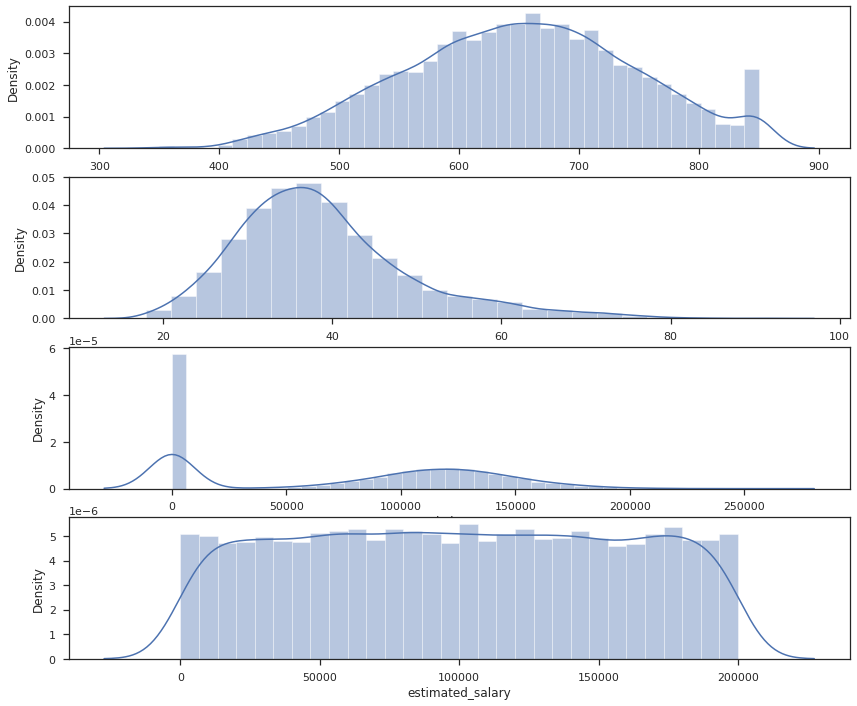

In [140]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,12))

sns.set_style("ticks")
#sns.axes_style("darkgrid")

sns.distplot(data_frame_1['credit_score'], ax=ax[0])
sns.distplot(data_frame_1['age'], ax=ax[1],bins=25)
sns.distplot(data_frame_1['balance'], ax=ax[2],bins=40)
sns.distplot(data_frame_1['estimated_salary'], ax=ax[3], bins=30)


plt.show()

Initial analysis shows that the estimated salary is well distributed along its range, from USD18.00 to almost USD200000.00. Also, the distribution of balance across different clients, shows that there are a high concentration of people with balance of USD0.00, while the median value is USD97000.00. 

### 1.5.2. Categorical attributes

In [141]:
categorical_att = data_frame_1[['customer_id','surname','geography','gender','has_cr_card','is_active_member','exited']]
categorical_att.head()

,customer_id,surname,geography,gender,has_cr_card,is_active_member,exited
0,15634602,Hargrave,France,Female,1,1,1
1,15647311,Hill,Spain,Female,0,1,0
2,15619304,Onio,France,Female,1,0,1
3,15701354,Boni,France,Female,0,0,0
4,15737888,Mitchell,Spain,Female,1,1,0


Before processing and analyzing the categorical variables, first we must undesrtand how many values exists in each categorical attribute.

In [142]:
categorical_att.apply( lambda x: x.unique().shape[0] )

customer_id         10000
surname              2932
geography               3
gender                  2
has_cr_card             2
is_active_member        2
exited                  2
dtype: int64

For instance, there are 10,000 unique customers, while there are 2,932 unique surnames, which means that the surname isn't a interesting variable since could exist two different customers with the same surname. Also, it is highly unlikely that a surname will have any impact on churn prediction.

In [143]:
categorical_att['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

For geography, we can see that clients comes from 3 different countries, such as: France, Spain and Germany. Despite the gender variable, which could be only male or female, all other categorical variables represents a true or false statement.

## 1.6. Splitting the dataset

Before following the process of analysis and model creation, we will split the data in two groups, one group for creating the model, and other for evaluating the business performance of the model created.

In [144]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data_frame_1, data_frame_1['exited']):
    model_creation_data = data_frame_1.loc[train_index]
    bussiness_performance_data = data_frame_1.loc[test_index]
    
print( 'Data available for model creation: {}'.format(model_creation_data.shape))
print( 'Data available for business performance evaluation: {}\n'.format(bussiness_performance_data.shape))
print( 'Churn rate on the data available for model creation: \n{}'.format(model_creation_data['exited'].value_counts(normalize=True)))
print( 'Churn rate on the data available for business performance evaluation: \n{}'.format(bussiness_performance_data['exited'].value_counts(normalize=True)))

Data available for model creation: (8000, 14)
Data available for business performance evaluation: (2000, 14)

Churn rate on the data available for model creation: 
0    0.79625
1    0.20375
Name: exited, dtype: float64
Churn rate on the data available for business performance evaluation: 
0    0.7965
1    0.2035
Name: exited, dtype: float64


In [145]:
# Saving those datasets for further usage.
model_creation_data.to_csv('data/processed/model_creation.csv', index=False)
bussiness_performance_data.to_csv('data/processed/evaluation.csv', index=False)

# 2. Feature Engineering

In [146]:
data_frame_2 = pd.read_csv('data/processed/model_creation.csv')

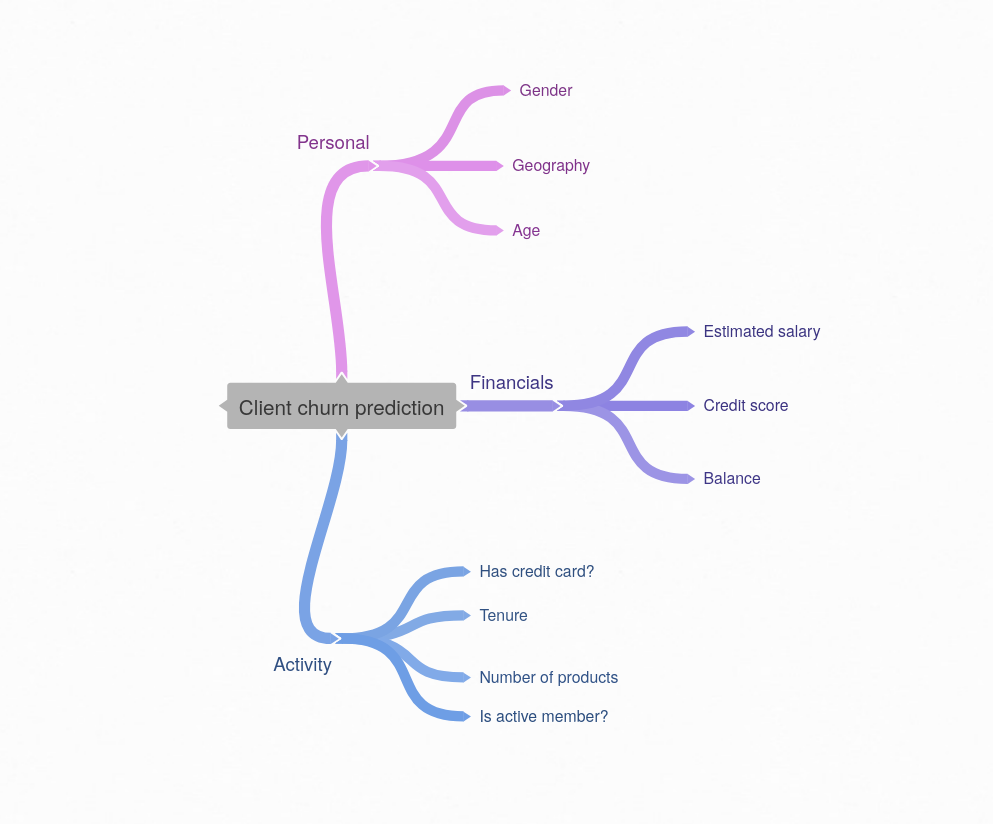

In [147]:
Image('img/MindMapHypothesis.png')

## 2.1. Hypothesis mental map

### 2.1.1. Personal information

**1.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability

**2.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits

**3.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits

### 2.1.2. Client financials

**4.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them.

**6.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them.

### 2.1.3. Activity information

**7.** Clients that have a credit card **should** have a lesser probability of churn

**8.** Clients with higher tenure **should** have a lesser probability of churn

**9.** Clients that uses a higher number of products **should** have a lesser probability of churn

**10.** Active clients **should** have a lesser probability of churn

## 2.2. Hypothesis priorization

The hypothesis priorization should be organized both in sense to test which hypothesis is true or based based on data **already** available and in which hypothesis there are some indications that have a higher impact on the churn prediction.

For example, we could consider this priorization:

**1.** Active clients **should** have a lesser probability of churn

**2.** Clients that uses a higher number of products **should** have a lesser probability of churn

**3.** Clients with higher tenure **should** have a lesser probability of churn

**4.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them

**6.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them.

**7.** Clients that have a credit card **should** have a lesser probability of churn

**8.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability

**9.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits

**10.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits

In this example, we are considering that information that somehow measures how active the client uses the product have a higher impact than the client's gender or geography.

## 2.3. Feature engineering

At this moment, we should make some transformations on the dataset in a way, such as it could be easier to manipulate the data on the next step and/or transforming existing data in new variables, such as divinding one date into day, month and year. For this dataset, is doest not seem necessary to work on this step.

# 3. Variable filtering

For each problem involving data science and analytics, the dataset may contain information that only does not help understanding the problem, but also may increase its difficulty. To solve this problem, we must filter the information before advancing to the exploratory data analysis. The information can be filtered by two different means: by the lines or by the columns.

## 3.1. Lines filtering

The line filtering involves removing information that are not reliable, does not helps the interpretation or the value of target variable have an important business meaning that explain the line removal.

For example, in a problem involving a store sales prediction, the information contained on a line informing sales of 0 in one day, may represents that, on this day, the store was closed. And this fact, **may** justify the line information.

For this dataset, we have 10,000 lines with 10,000 different customersId and we only have values for the target variable of 0 or 1, meaning that the customer churned or not, so we will not remove any lines.

## 3.2. Columns filtering

Each column in a dataset represent one variable or some aspect of one variable (such as time could be divided in different variables, such as year, month and day), thus making the columns filtering the equivalent of variable filtering.

In this dataset, we can see that there are information that does not help the client churn prediction, for example: surname, row number and customer ID. It is highly unlikely that those variables will have any impact on any prediction model. Thus, we will be removing the surname and row number columns and will keep the customer's ID **only** for data traceability.

In [148]:
cols_drop = ['row_number','surname']

This change in the dataset reduces the dimensions from 10,000 rows and 14 columns to 10,000 rows and **12** columns

# 4. Exploratory data analysis

In [149]:
data_frame_4 = data_frame_2.copy()

On the exploratory data analysis the main objective is to extract insights for the business problem, by: **(a).** confirming or rejecting the hypothesis created, **(b).** proving wrong old beliefs from the business team or **(c).** finding new information that helps the business team.

## 4.1. Univariate analysis

On the first step of the analysis, we will study how the response variable interacts with the variation of the others variables and asking the questions:

**(i).** Is it expected to see this behavior?

**(ii).** Does the business team knows this behavior?

**(iii).** Is there any business reason that explains this behavior?

### 4.1.1. Response variable

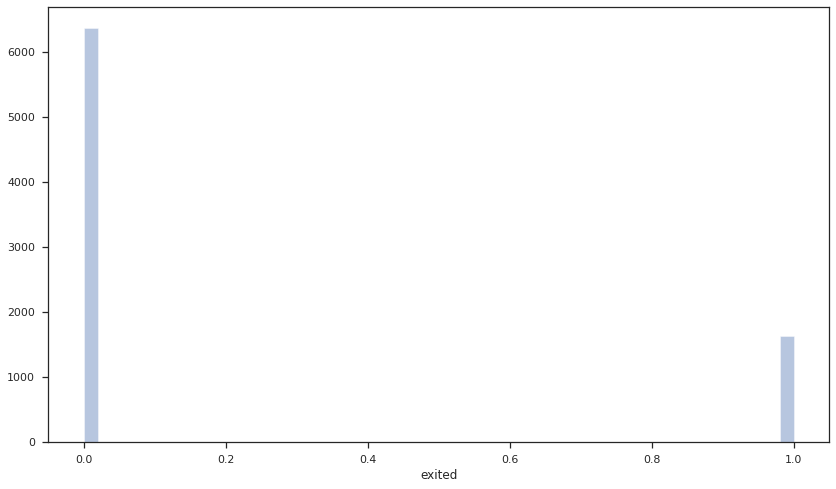

In [150]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,8))

sns.set_style("ticks")

sns.distplot(data_frame_4['exited'], kde=False, rug=False )

plt.show()

From the distribution graph, we can see that the proportion between customers that have churned is 20\% of the dataset, while clients that have not churn is 80\%. With this information we already know that we are dealing with a problem of disbalanced data, thus making necessary using appropriated methods for those types of problems.

### 4.1.2 Numerical variables

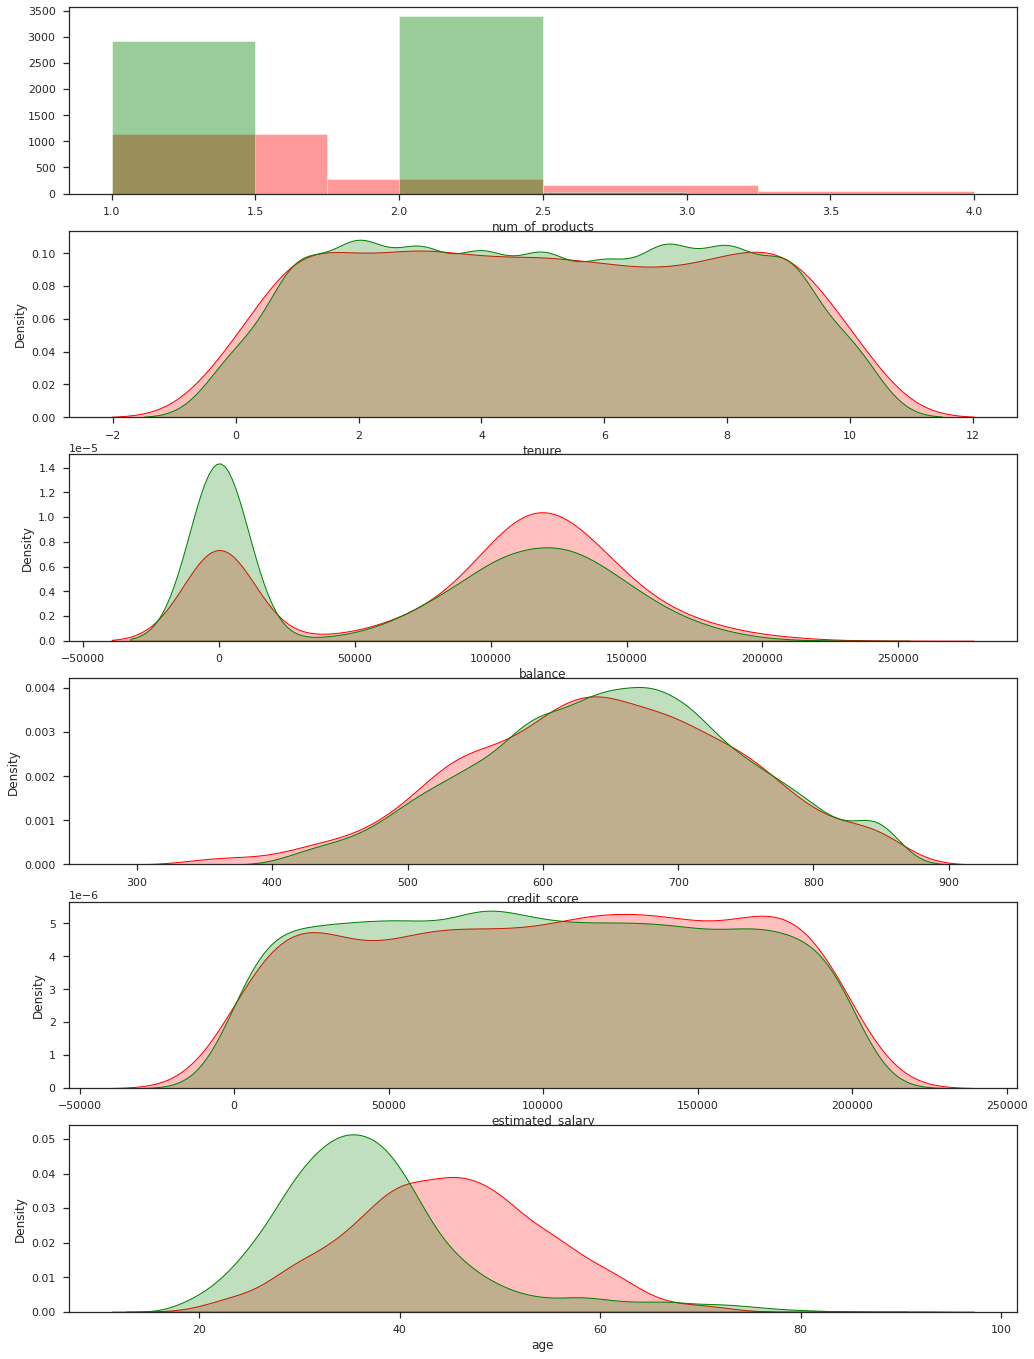

In [151]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(17,24))

sns.set_style("ticks")

# Plot 1
sns.distplot( data_frame_4[data_frame_4['exited'] == 1]['num_of_products'], label='Churned', ax=ax[0], kde=False, bins=4, color='red')
sns.distplot( data_frame_4[data_frame_4['exited'] == 0]['num_of_products'], label='Not churned', ax=ax[0], kde=False, bins=4, color='green')

# Plot 2
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['tenure'], label='Churned', shade=True, ax=ax[1], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['tenure'], label='Not churned', shade=True, ax=ax[1], color='green')

# Plot 3
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['balance'], label='Churned', shade=True, ax=ax[2], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['balance'], label='Not churned', shade=True, ax=ax[2], color='green')

# Plot 4
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['credit_score'], label='Churned', shade=True, ax=ax[3], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['credit_score'], label='Not churned', shade=True, ax=ax[3], color='green')

# Plot 5
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['estimated_salary'], label='Churned', shade=True, ax=ax[4], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['estimated_salary'], label='Not churned', shade=True, ax=ax[4], color='green')

# Plot 6
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 1]['age'], label='Churned', shade=True, ax=ax[5], color='red')
sns.kdeplot( data_frame_4[data_frame_4['exited'] == 0]['age'], label='Not churned', shade=True, ax=ax[5], color='green')


plt.show()

From the graphs, we can already evalute some of the hypothesis from the section 2: 

**2.**  Clients that uses a higher number of products **should** have a lesser probability of churn. From graph 1, we can see that most of the churn customers (around 1,500 or 75% of all churned customers) only consumes a single product from the company, while most of the customers uses 2 products (around 4,000 or 40% of all customers). Also, we see that almost every customer that used 3 or 4 products became churn. Thus, making this hypothesis **partially false**, while having a single product the customer has a higher probability of churn, increasing the products to 3 or 4 also increases the probability of churn.

**3.** Clients with higher tenure **should** have a lesser probability of churn. From graph 2, we can see that this hypothesis is also **false**, since there almost the same proportion of churn and not churned customers across different values of tenure.

**4.** Clients with higher balance **should** have a higher probability of churn, since other companies **may** try to attract them. Graph 3 shows that the proportion of churned and not churned customers is different, for different values of balance. For instance, we can see that there is a higher proportion of not churned customers with USD0.00 balance, while a higher proportion of churned customers with a higher balance, peaking at around USD125,000.00. So, this hypothesis is **true**.

**5.** Clients with higher credit score **should** have a higher probability of churn, since other companies **may** try to attract them. The data shows almost no difference in credit score and churn probability, thus making this hypothesis **false**.

**6.** Clients with higher salaries **should** have a higher probability of churn, since other companies **may** try to attract them. This hypothesis is also **false**, since there are no significant difference in churned and not churned customers across different values of salary.

**8.** Clients with higher age **should** have a lesser probability of changing its consuming habits, thus reducing the churn probability. From the last graph, we can see that the increase of age impacts negatively on the probability of churn, making the hypothesis **false**.  

### 4.1.3. Categorical variables

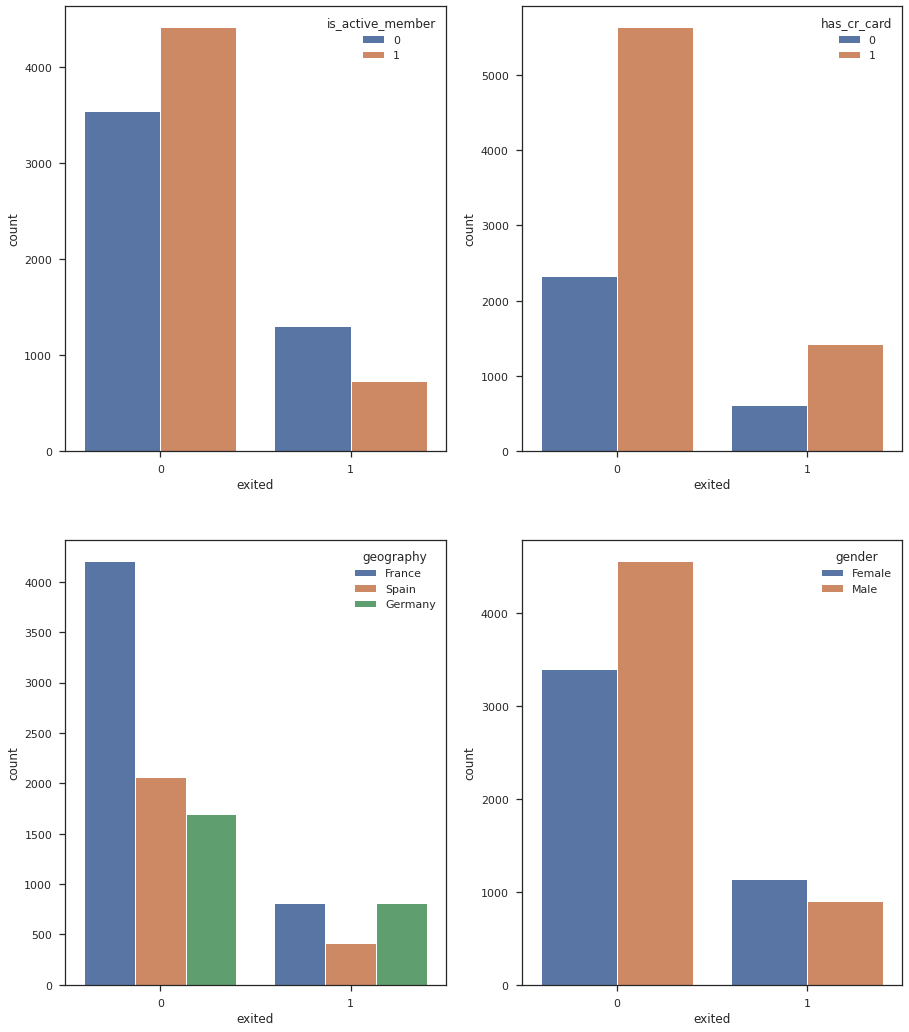

In [152]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,18))

sns.set_style("ticks")
#sns.axes_style("darkgrid")

sns.countplot(x="exited", hue="is_active_member", data=categorical_att, ax=ax[0,0])
sns.countplot(x="exited", hue="gender", data=categorical_att, ax=ax[1,1])
sns.countplot(x="exited", hue="has_cr_card", data=categorical_att, ax=ax[0,1])
sns.countplot(x="exited", hue="geography", data=categorical_att, ax=ax[1,0])
#sns.catplot(x="geography", y="exited", hue="has_cr_card",kind="violin", split=True, data=categorical_att)
#sns.catplot(x="geography", y="exited", hue="is_active_member",kind="violin", split=True, data=categorical_att)


plt.show()

**1.** Active clients **should** have a lesser probability of churn. The first graph shows that the more active a customer is, the lesser is the probability of becoming churn. So, the hypothesis is **true**.

**7.** Clients that have a credit card **should** have a lesser probability of churn. Clients with credit card becomes churn in a slightly lesser proportion (1424/5631 or 25%) than client without credit card (613/2332 or 26%). Thus, making the hypothesis **partially true**.

**9.** Clients from different nationalities **should** have different probabilities of churn, since the cultural differences **may** impact consuming habits. German customershave a higher probability to become churn, while french customers have a lesser probability, making the hypothesis **true**.

**10.** Male and female clients **should** have different churn probabilities, since gender **may** have some impact on consuming habits. The last graph shows that male customers have a lower probability of becoming churn compared to female customers, making the hypothesis **true**.

## 4.2. Bivariate analysis

From the analysis done before, we have observed that the features which causes the most variation in churn or not churn probability for numerical variables are: age, balance and number of products and the categorical attributes are: active member, geography and gender.

Those observations brings some more hypothesis to be made, such as:

**11.** Active member churn probability **could** be different for men and women.

**12.** Active member churn probability **could** be different different ages.

**13.** Men and women from different countries **could** have different churn probabilities.

**14.** Men and women with different ages **could** have different churn probabilities.

**15.** People with different age along each country **could** have different churn probabilities.

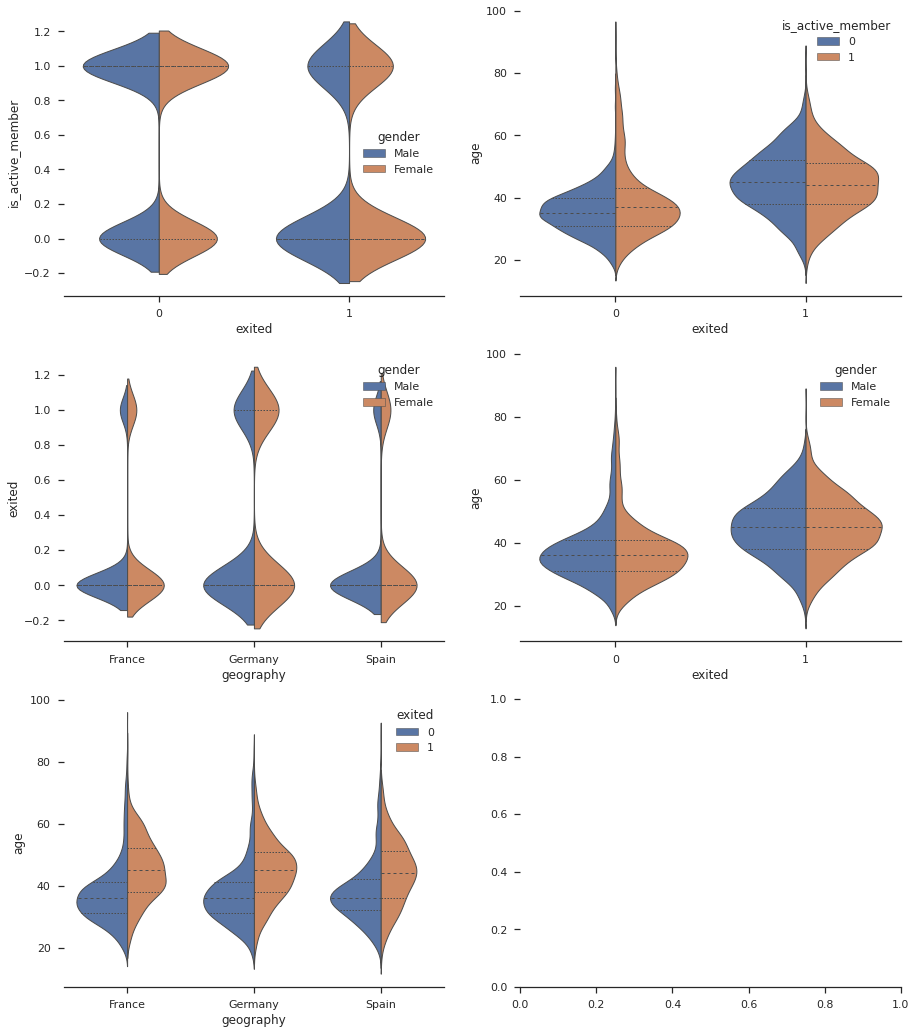

In [153]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,18))

# Plot 1
sns.violinplot(data=data_frame_4, x="exited", y="is_active_member", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[0,0])


# Plot 2
sns.violinplot(data=data_frame_4, x="exited", y="age", hue="is_active_member", split=True, inner="quart", linewidth=1, ax=ax[0,1])

# Plot 3
sns.violinplot(data=data_frame_4, x="geography", y="exited", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[1,0])

# Plot 4
sns.violinplot(data=data_frame_4, x="exited", y="age", hue="gender", split=True, inner="quart", linewidth=1, ax=ax[1,1])

# Plot 5
sns.violinplot(data=data_frame_4, x="geography", y="age", hue="exited", split=True, inner="quartiles", linewidth=1, ax=ax[2,0])



sns.despine(left=True)
plt.show()

**11.** Active member churn probability **could** be different for men and women. From the first graph, differences between male and female exited customers are not clear among active and inactive members. So, the hypothesis is **false**.

**12.** Active member churn probability **could** be different different ages. From the second graph, we can see that there is a difference in age profile for non churned customers, with a skewness for older clients. However, there are no clear difference of age among churned customers. So, the hypothesis is **false**.

**13.** Men and women from different countries **could** have different churn probabilities. The third graph (first column, second row) shows a higher proportion of male non churned customers while, women have higher churn probability. Also, the graph makes clear how german clients have the highest churn probability. As women have highest churn probability in all countries, the hypothesis is **false**. 

**14.** Men and women with different ages **could** have different churn probabilities. The fourth graph shows that there are no clear evidence that male and female churn probability varies with age. Thus, the hypothesis is **false**.

**15.** People with different age along each country **could** have different churn probabilities. The last graph shows clearly that there is a difference in churned customers with age along all countries available. 

## 4.3. Multivariate analysis

### 4.3.1. Numerical attributes

The multivariate analysis for numerical attributes consists in evaluating the correlation between different variables, without the target, by using Person's correlation.

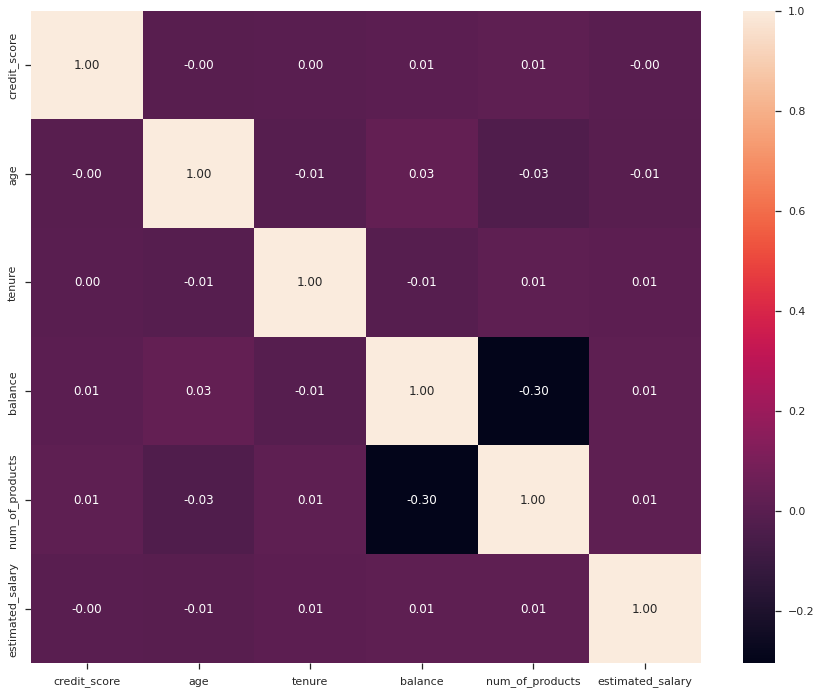

In [154]:
fig, ax = plt.subplots(figsize=(15,12))

correlation = numerical_att.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt='.2f')

plt.show()

For the dataset we do not observe any correlation between almost all variables, even those which we might think that is correlate, such as: bigger salaries should imply in bigger balances or bigger balances should imply high credit score. However, we do not observe those kind of things. 

The biggest correlation observed is between balance and number of products consumed, which could imply that the lower the balance, the more products are consumed. This correlation could be spurious since there are a lot of customers with USD0.00 balance and a lot of people who consumes two products.

### 4.3.2. Categorical attributes

For categorical attributes, we use the Pearson's chi-squared test to evaluate correlation between those variables. The method used for this calculation can be found at the item **0.2. Helper Functions**.

In [155]:
cat1 = cramer_v(categorical_att['geography'], categorical_att['gender'])
cat2 = cramer_v(categorical_att['geography'], categorical_att['is_active_member'])
cat3 = cramer_v(categorical_att['geography'], categorical_att['has_cr_card'])
#cat4 = cramer_v(categorical_att['geography'], categorical_att['exited'])


cat5 = cramer_v(categorical_att['gender'], categorical_att['geography'])
cat6 = cramer_v(categorical_att['gender'], categorical_att['is_active_member'])
cat7 = cramer_v(categorical_att['gender'], categorical_att['has_cr_card'])
#cat8 = cramer_v(categorical_att['gender'], categorical_att['exited'])

cat9 = cramer_v(categorical_att['is_active_member'], categorical_att['gender'])
cat10 = cramer_v(categorical_att['is_active_member'], categorical_att['geography'])
cat11 = cramer_v(categorical_att['is_active_member'], categorical_att['has_cr_card'])
#cat12 = cramer_v(categorical_att['is_active_member'], categorical_att['exited'])

d = pd.DataFrame({'geography': [cat1, cat2, cat3],
              'gender': [cat5, cat6, cat7],
              'is_active_member': [cat9, cat10, cat11] })

d = d.set_index(d.columns)
d.head()

,geography,gender,is_active_member
geography,0.026303,0.026303,0.022344
gender,0.023033,0.022344,0.023033
is_active_member,0.014951,0.005545,0.011646


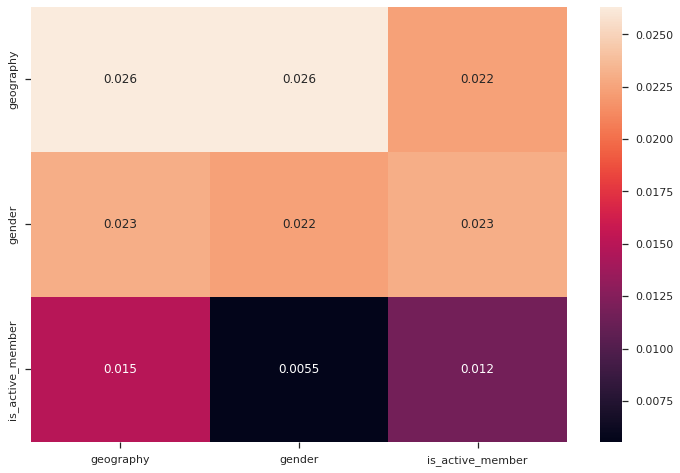

In [156]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(d, annot=True)

plt.show()

Even for the categorical attributes, we can not see any clear correlation between the different variables.

# 5. Data preparation

In [163]:
data_frame_5 = data_frame_4.copy()

At this point all data must be properly prepared for the application of machine learning algorithms. The preparation includes: (a) changing variables range of value to a smaller one, so all numerical variables have the same or almost the same importance for the machine learning algorithm, and  (b) transforming categorical attributes into numerical values.

## 5.1. Data normalization

The data normalization is one type of rescaling data where the variable becomes a value with a mean equal of 0 and with a deviation of one. This transformation is good with numerical variables which have a distribution similar to a "bell" curve. For this dataset, all numerical variables seem to have some skewness and/or kurtosis or is a bimodal distribution. So, for this dataset, we will not perform any data normalization.

## 5.2. Data rescaling

In the other hand, the data rescaling have a good performance for variables with a non-normal distribution. The main types of rescaling are: the min-max scaler or the robust scaler. The min-max scaler is good option because it keeps the distribution curve behavior for numerical variables. However, this scaler does not have a good performance for variables with outliers, because the rescaling of data happens by using minimun and maximum values of the variable. The robust scaler method were developed to solve thhe outlier problem, where the rescaling of data uses the first and the last quartile.

For this dataset, we will be using only the min-max scaler as we do not see any problem with outlier values.

In [164]:
mms = MinMaxScaler()

# credit score
data_frame_5['credit_score'] = mms.fit_transform( data_frame_5[['credit_score']].values )
pickle.dump(mms, open('parameters/credit_score.pkl','wb'))

# age
data_frame_5['age'] = mms.fit_transform( data_frame_5[['age']].values )
pickle.dump(mms, open('parameters/age.pkl','wb'))

# tenure
data_frame_5['tenure'] = mms.fit_transform( data_frame_5[['tenure']].values )
pickle.dump(mms, open('parameters/tenure.pkl','wb'))

# balance
data_frame_5['balance'] = mms.fit_transform( data_frame_5[['balance']].values )
pickle.dump(mms, open('parameters/balance.pkl','wb'))

# num_of_products
data_frame_5['num_of_products'] = mms.fit_transform( data_frame_5[['num_of_products']].values )
pickle.dump(mms, open('parameters/num_of_products.pkl','wb'))

# estimated_salary
data_frame_5['estimated_salary'] = mms.fit_transform( data_frame_5[['estimated_salary']].values )
pickle.dump(mms, open('parameters/estimated_salary.pkl','wb'))

## 5.3. Data transformation

For the transformation, we will change the non-numerical attirbutes into numerical values. This dataset has only two variables which behaves this way: geography and gender. We already discussed in other sections that the variable surname will not be considered, since it is highly unlikely that this feature will increase the model's precision.

### 5.3.1. Enconding

The variable gender will be treated with the one hot encoding which creates two other variables with values of 0 or 1. The variables will refer to male or female and if it is 1 for male, it will be 0 for female. This way we can represent the differences between gender as observed in the EDA while slightly increasing the model's complexity.

In [165]:
data_frame_5 = pd.get_dummies(data_frame_5, prefix='gender', columns=['gender'])

The same process describe above will be applied for the geography feature

In [166]:
#mean_encode = data_frame_5.groupby('geography')['exited'].mean()
data_frame_5 = pd.get_dummies(data_frame_5, prefix='geography', columns=['geography'])
#data_frame_5.loc[:, 'geography_mean_enc'] = data_frame_5['geography'].map(mean_encode)

In [167]:
data_frame_5.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'gender_Female', 'gender_Male',
       'geography_France', 'geography_Germany', 'geography_Spain'],
      dtype='object')

### 5.3.2. Response variable transformation

At this point, it could be necessary to transform the values in the target variable, so its range could also be reducted. However, our target is already in a well behaved range from 1 (churned customer) to 0 (not churned). So, it will not be done any modification in the response variable.

# 6. Feature selection

In [168]:
data_frame_6 = data_frame_5.copy()
data_frame_6 = data_frame_6.drop(columns=['surname', 'row_number', 'customer_id'], axis=1)

At this point, it is necessary to select the most relevant features to train and test the model. Since we have a small number of features, the selection could be done manually or by using a feature selector method/function, such as the Boruta.

The selected features that will be chosen manually for the training will be: credit score, geography mean encode, tenure, balance, age, estimated salary, number of products, has credit card, is active member, gender female and gender male. So, the features: customer ID, row number, surname and original geography will not be used.

In [169]:
manual_selected = ['credit_score', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'gender_Female', 'gender_Male',
       'geography_France', 'geography_Germany', 'geography_Spain']
data_frame_6['exited'] = data_frame_6['exited'].astype(float)

Removing unnecessary data and spliting data between train and test.

In [170]:
X = data_frame_6.drop('exited', axis=1)
y = data_frame_6['exited']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)


#x_train = data_frame_6.drop(['customer_id','row_number','surname', 'geography', 'exited'], axis=1)

#y_train = data_frame_6['exited'].copy()
#x_balanced.head()

However, we can also use a feature selection algorithm to evaluate the what are the most important features. The chosen algorithm will be the random forest regressor.

In [171]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(x_train, y_train)

feature_imp = pd.DataFrame({'Feature':x_train.columns, 'feature_importance': rf.feature_importances_}).sort_values('feature_importance', ascending=False).reset_index(drop=True)

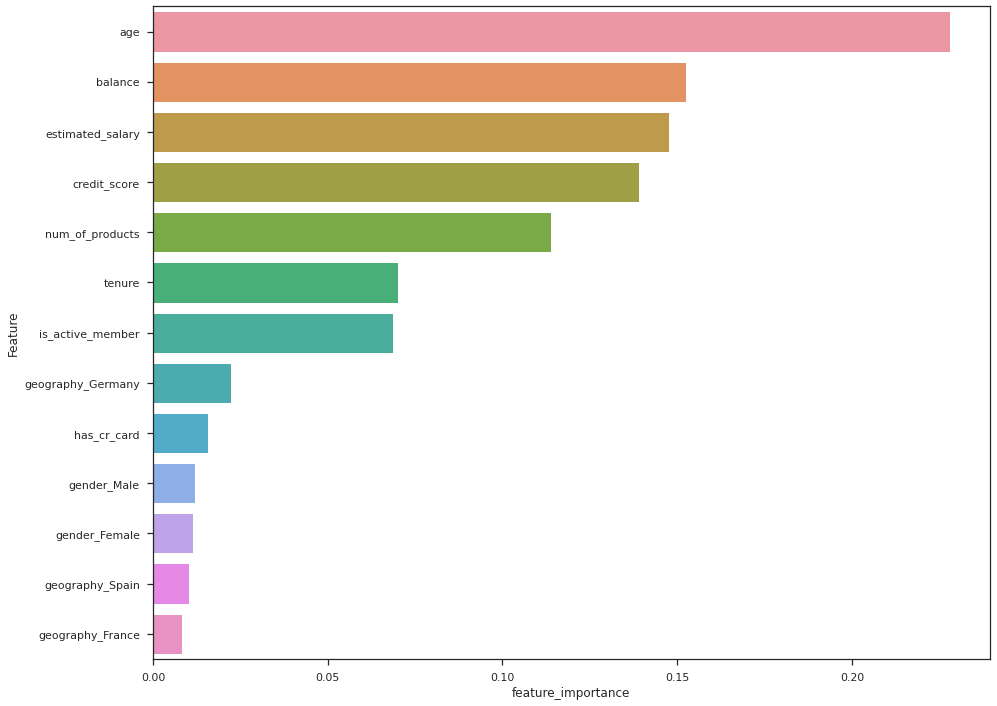

In [172]:
fig, ax = plt.subplots(figsize=(15,12))

sns.barplot(x='feature_importance', y='Feature', data=feature_imp, orient='h')

plt.show()

In [173]:
x_train_boruta = x_train.values
y_train_boruta = y_train.values.ravel()

boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_boruta ,y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration:

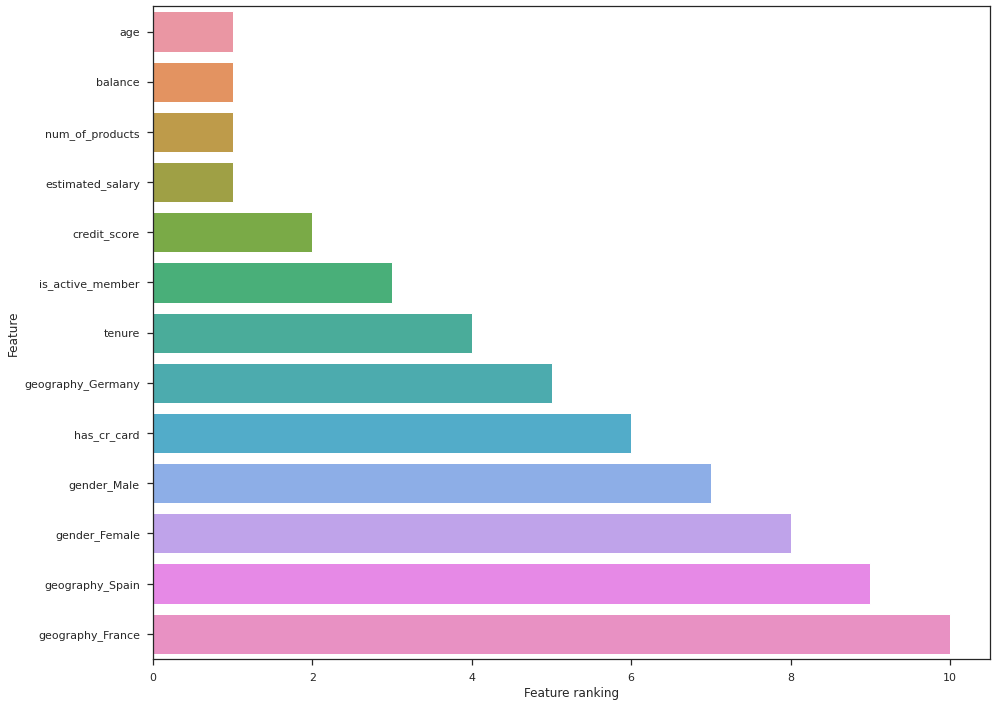

In [174]:
d = {'Features':x_train.columns, 'feature_importance': boruta.ranking_}
features_boruta = pd.DataFrame(d).sort_values('feature_importance', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,12))

ax = sns.barplot(x='feature_importance', y='Features', data=features_boruta, orient='h')

ax.set(xlabel='Feature ranking', ylabel='Feature')

plt.show()

Boruta and the random forest regressor concludes the same things, the age, balance and estimated salary are the most important features while the gender for female or male are the least important. The result is controversial as the EDA shows that there are different proportion for men and women with churn. 

In the first model, we will keep all the features above, however in a next attempt for model optimization we may need to create new features or remove some of the least informative.

# 7. Machine learning modelling

After treating data both by removing non-valid data and by rescaling the features to a narrow range of values and transforming categorical data into numerical data, the next step is to train different machine learning algorithms and evaluate its accuracy and precision metrics, in order to select the best model.

## 7.1. Balancing data for training

Before training the data, it is necessary to treat the problem with unbalanced data. The problem with unbalanced data is that, if a model is training with such dataset, it will have a higher probability to predict the result present in the most frequent target variable value. Thus, a machine learning model trained in this way may have and incorrect bias.

The problem is evident, since the dataset is that it is highly unbalanced with a total proportion of 80% of customers not churned and 20% of churned customers.

To solve this problem, the data for training and for testing will be balanced with the SMOTE algorithm.

**Theory behind SMOTE**: the algorithm's initials stands for **Synthetic Minority Oversampling TEchnique** and it works by created new data of the least frequent value of the target variable. The criteria used to create the new data is to select points of the least frequent data that are close to each other, create a line between the closest points, then create new data along those lines. Note that all data created follows the principle that: if you have a dataset with 80 samples of target value A and 20 values of target value B, the algorithm will create 60 new data points with target value B. This way the dataset will contain a total of 160 data points, where the 60 new data will be synthetic data.  

In [175]:
# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

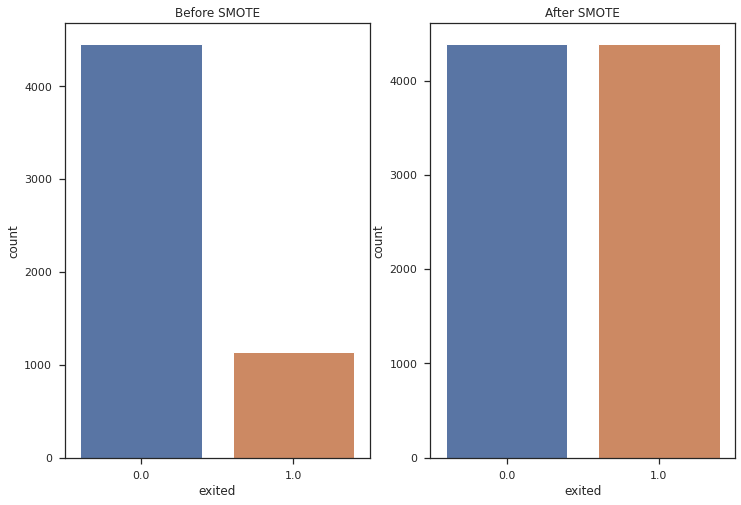

In [176]:
 # plots before and after SMOTETomek
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced)
plt.title("After SMOTE")

plt.show()

## 7.2. Logistic model

The logistic **regression** model can be used both in **regression** problems and in **classification** problems where the target variable is a binary value, such as "yes or no", "true or false" that can be translated in 0's and 1's. The model uses the sigmoid function and tries to predict the probability of a given customers to become churn or to remain active (not churn). For instance, the model results values in a continuos scale between 0 and 1, where 1 means churned and the continuos values represents the churn probability. But we do not want to know the probability, we want to know which customers will become churn, so what the model does is to make a cut on the probability values, such as predicted values higher than 0.50 will classify customer as churn, while values lesser than 0.50 will classify as not churn.

### 7.2.1. Unbalanced data

In [177]:
 # instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance = performance(logit, x_train, y_train)
logit_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.811786,0.615361,0.209466,0.311732,0.58769,0.278076


In [178]:
logit_y_pred = cross_val_predict(logit, x_train, y_train, cv=10)

logit_cm = confusion_matrix(y_train, logit_y_pred)

logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

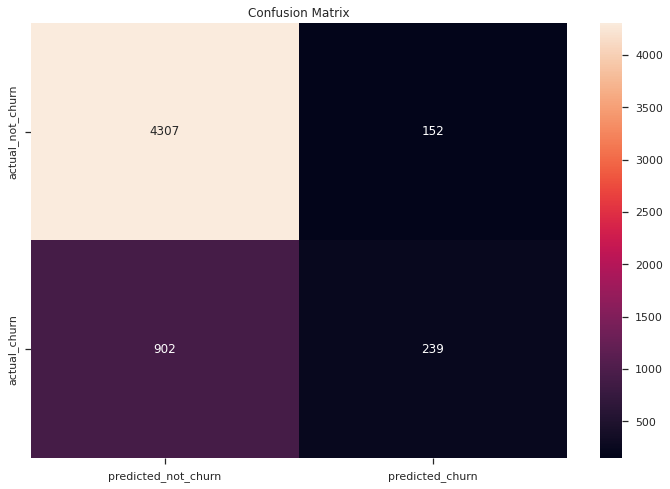

In [179]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.2.2. Balanced data

In [180]:
 # instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance_bal = performance(logit, x_balanced, y_balanced)
print(logit_performance_bal)

   test_accuracy  test_precision  test_recall  test_f1_score  test_roc_auc_score  test_mcc
0       0.714531        0.720197      0.70189       0.710872            0.714531  0.429264


In [181]:
logit_y_pred_bal = cross_val_predict(logit, x_balanced, y_balanced, cv=10)

logit_cm_bal = confusion_matrix(y_balanced, logit_y_pred_bal)

logit_cm_df_bal = pd.DataFrame(logit_cm_bal, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

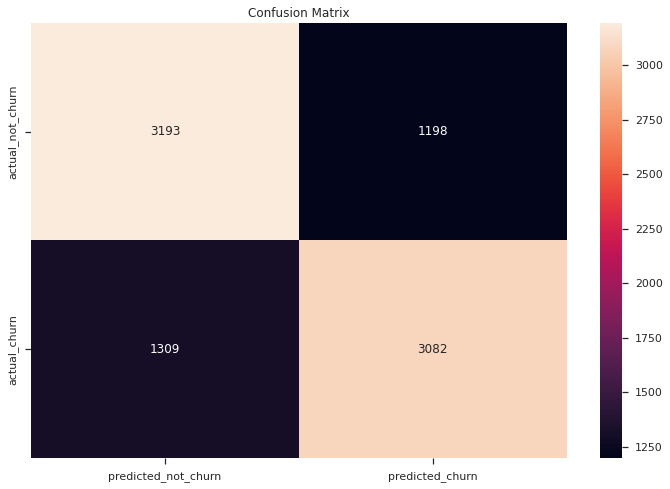

In [182]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(logit_cm_df_bal, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

## 7.3. Random forest

The model consists in the concept of the decision trees to create subsets of the dataset, then classifying the leaves (represented by the end of the tree). The algorithm creates a collection of decision trees, thus creating the name of forest, and it is done by generating individual trees with an attribute selection indicator, such as information gain, gain ratio and Gini index for each attribute. In the algorithm, each tree depends of an independent random sample and each one votes for a class. The most popular class is the final result. 

**Random Forest theory**: the algorithm can be divided in 4 steps: (1) select random samples of the dataset, (2) construct a decision tree for each sample and get a prediction result from each one, (3) perform a vote for each predicted result, then (4) select the prediction result with the most votes as the final prediction.

### 7.3.1. Unbalanced data

In [183]:
 # instantiate the model
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

# fit the model
rfc.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
rfc_performance = performance(rfc, x_train, y_train)
rfc_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.863036,0.783418,0.455706,0.574955,0.711481,0.526935


In [184]:
rfc_y_pred = cross_val_predict(rfc, x_train, y_train, cv=10)

rfc_cm = confusion_matrix(y_train, rfc_y_pred)

rfc_cm_df = pd.DataFrame(rfc_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

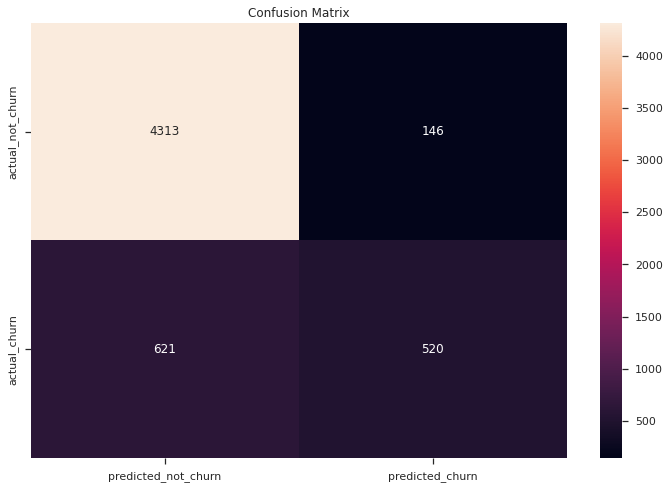

In [185]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(rfc_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.3.2. Balanced data

In [186]:
 # instantiate the model
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

# fit the model
rfc.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
rfc_performance_bal = performance(rfc, x_balanced, y_balanced)
rfc_performance_bal

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.90721,0.901874,0.913949,0.906266,0.907214,0.817191


In [187]:
rfc_y_pred_bal = cross_val_predict(rfc, x_balanced, y_balanced, cv=10)

rfc_cm_bal = confusion_matrix(y_balanced, rfc_y_pred_bal)

rfc_cm_df_bal = pd.DataFrame(rfc_cm_bal, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

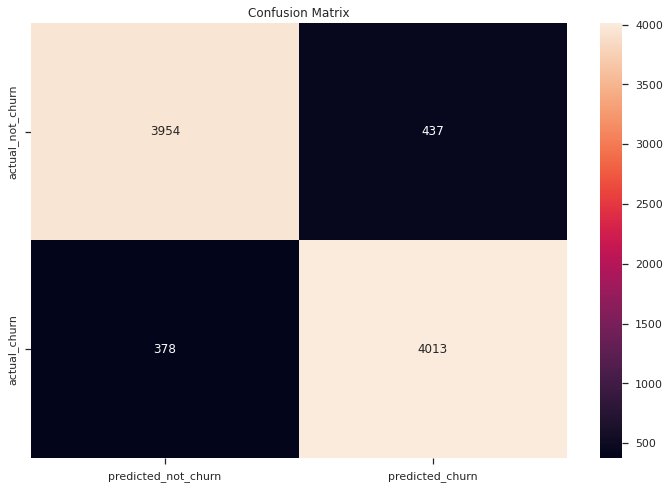

In [188]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(rfc_cm_df_bal, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

## 7.4. XGBoost model

The initials of the model stands for Extreme Gradient Boosting (XGB) and it belongs to a type of of gradient boosting algorithms. The boosting is a technique which consists of the improvement of weak learners (weak learner is one which is slightly better than random guessing). At first, different classifiers try to split the between the binary options for the target variable, then each classifier is weighted in order to create a new one that is a combination of the previous ones. This procedure keep advancing in a such a way that for a instant t, the model is a weighted combination of the results obtained from t-1. 

The basic idea of the model is to start building a weak model, evaluating the importance of different features and parameters, then using this information to build a new better model, by capitalizing on the misclassification and errors on the previous model.

### 7.4.1. Unbalanced data

In [189]:
 # instantiate the model
xgbc = XGBClassifier(random_state=42,n_jobs=-1)

# fit the model
xgbc.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
xgbc_performance = performance(xgbc, x_train, y_train)
xgbc_performance

[11:48:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.853929,0.70327,0.493402,0.579142,0.719789,0.505904


In [190]:
xgbc_y_pred = cross_val_predict(xgbc, x_train, y_train, cv=10)

xgbc_cm = confusion_matrix(y_train, xgbc_y_pred)

xgbc_cm_df = pd.DataFrame(xgbc_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

[11:48:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

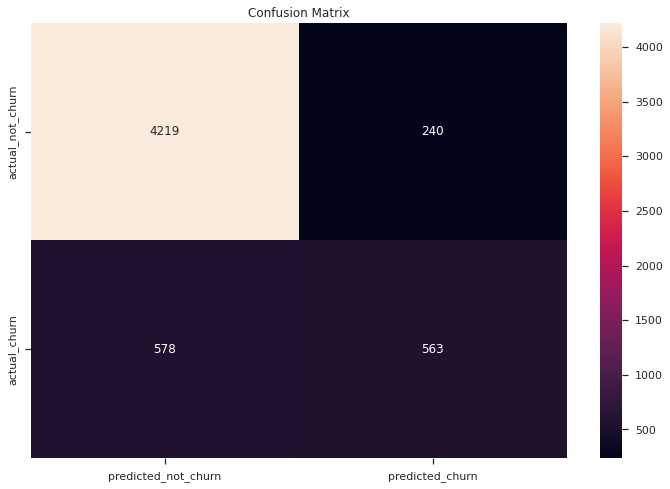

In [191]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(xgbc_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

### 7.4.2. Balanced data

In [192]:
 # instantiate the model
xgbc = XGBClassifier(random_state=42,n_jobs=-1)

# fit the model
xgbc.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
xgbc_performance_bal = performance(xgbc, x_balanced, y_balanced)
xgbc_performance_bal

[11:48:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.900173,0.921602,0.873221,0.886569,0.900171,0.811911


In [193]:
xgbc_y_pred_bal = cross_val_predict(xgbc, x_balanced, y_balanced, cv=10)

xgbc_cm_bal = confusion_matrix(y_balanced, xgbc_y_pred_bal)

xgbc_cm_df_bal = pd.DataFrame(xgbc_cm_bal, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

[11:48:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

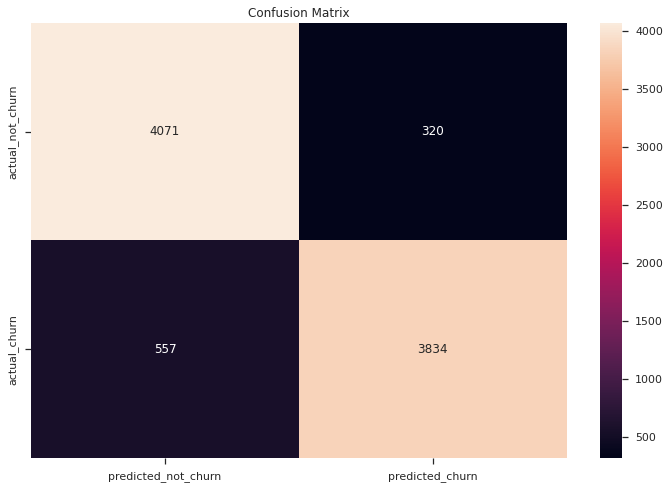

In [194]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(xgbc_cm_df_bal, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

## 7.5. Models performance comparison

With different trained models both with unbalanced (original data) and with balanced dataset, now it is time to compare the quality of the models and select which one will be used on the next steps. The metrics that will be evaluated are the classic metrics for classification problems:

**Accuracy**: the accuracy measures the proportion of true values among all values inside the confusion matrix and it can be calculated by the division of the sum of true positives and negatives by the sum of all values whithin the matrix.

**Precision**: the precision measures the proportion of positives that are true positives, and it is calculated by dividing the number of true positives by sum of true positives **and false positives**. It is commonly used to detected problems where the model is overestimating the positives by creating a high amount of false positives, which makes the metric more distant to 1. The closer it is from the value 1, the better.

**Recall (or Sensitivity)**: the metric measures the proportion of postives that are accurately predicted as positives, and it is done by dividing the number of true positives by sum of true positives **and false negatives**. In contrast of precision, the focus of the recall is to look for the problem with data that should be predicted as positive and was predicted by negative (false negative), so we want that the number of false negatives is as small as possible, so the better value for the metric is the value 1.

**F1-Score**: this metric relates the precision and the recall, by taking into account both problems with false negatives and false positives. It can be calcuted by dividing precision plus recall from 2 times precision times recall, so if either precision or recall has a low value, the F1-score will also have a low value. The highest possible value is if both precision and recall have a value of 1, making the F1-score also equal 1.

**AUC-ROC Score**: the metric initials stands for area under curve (AUC) and receiver operating characteristics (ROC) and the metric is calculated by creating a graph where the x-axis receives the false positive rate (FPR) and the y-axis, the true positive rate (TPR). Then the ROC curve is ploted and the area beneath it is calculated (AUC). The TPR is calculated is the recall, while the FPR is equal to 1 minus precision. The metric basically represents the capacity of the model to separate the dataset and precisely classify the data, where the AUC equal to 1 represents a model that completely separates both categories of values (churn and not churn), when the values diverge from 1, it means that part of the data will be overlapping, inferring that customers with false positive and false negative will be present.

**Matthew Correlation Coefficient (MCC)**: this metric is trickier to calculate and it can be done by dividing the product of true values minus the product of false values by the square root of the product of each sum combination between a true value and a false value. The closer the metric is equal to 1, means that the model predicts correctly the four possibilities in the confusion matrix, with a high proportion of true values (both positive and negative) and a low amount of false values. The metric is specially good if the occurence of false positives and false negatives have the same importance.

In [195]:
 # performance comparison data frame
performance_comp = pd.concat([logit_performance, rfc_performance, xgbc_performance])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.811786,0.615361,0.209466,0.311732,0.587690,0.278076
Random Forest,0.863036,0.783418,0.455706,0.574955,0.711481,0.526935
XGBoost,0.853929,0.703270,0.493402,0.579142,0.719789,0.505904


In [196]:
 # performance comparison data frame
performance_comp_bal = pd.concat([logit_performance_bal, rfc_performance_bal, xgbc_performance_bal])
performance_comp_bal.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp_bal['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp_bal = performance_comp_bal[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp_bal.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.714531,0.720197,0.701890,0.710872,0.714531,0.429264
Random Forest,0.907210,0.901874,0.913949,0.906266,0.907214,0.817191
XGBoost,0.900173,0.921602,0.873221,0.886569,0.900171,0.811911


From the comparison of all model results between the two different datasets (in terms of balanced data), it can be seen clearly that all models with the unbalanced data have low values of the recall and MCC metrics, which means that exist a high proportion of false values and the difference between the recall and precision shows that the false values are leaning towards an increase of false negatives. This problem can be related by the reason of the unbalanced data, since the improvement of the Logistic Regression model can be seen clearly after the data balancing, despite the decrease of accuracy all other metrics have increased.

The results shows that the best model observed is the Random Forest classifier, with the highest value of every metric calculated. Thus, the model to be used in every step forward will be the Random Forest classifier model.

# 8. Hyperparameter fine tuning

With the machine learning algorithm model already defined, it is necessary to make a fine tuning on the model's parameters in order to increase its accuracy and/or precision. There are many different ways to make this parameter tuning, where one of the fastest ways is with the random search method.

## 8.1. Random search method

This tuning method consists in defining a range of values of each parameter, then the model is trained and test many different parameters combination. By doing this, it is possible to achieve such a combination of parameters that have a higher accuracy and precision than what was achieved before.

In [197]:
param = {'n_estimators':[100, 300, 600, 900, 1200, 1500],
         'criterion':["gini", "entropy"],
         'max_depth':[3, 6, 9, 12, None],
         'max_features':['sqrt','log2', None],
         'min_impurity_decrease':[0.0, 0.025, 0.1],
        }

MAX_EVAL = 25

In [198]:
#model

run_fine_tuning = False

if run_fine_tuning:
    final_result = pd.DataFrame()

    for i in range(MAX_EVAL):

        hp = { k:random.choice(v,1)[0] for k, v in param.items()}

        print(i)
        print(hp)

        # instantiate the model
        rfc = RandomForestClassifier(n_estimators=hp['n_estimators'],
                                     criterion=hp['criterion'],
                                     max_depth=hp['max_depth'],
                                     max_features=hp['max_features'],
                                     min_impurity_decrease=hp['min_impurity_decrease'],
                                     n_jobs=-1, random_state=42)


        # performance
        rfc.fit(x_balanced, y_balanced)
        result = performance(rfc, x_balanced, y_balanced)
       #print(result)
        final_result = pd.concat([final_result, result])

    print(final_result)

Even after searching for a better model than used on the previous section, by using different available parameter for the Random Forest model, it seems that all default parameters works better than the variation of different parameters, it can be seem by the 5th iteration results that has the better results, the closer the parameters are from the default values. The final model will consist of the Random Forest with default values, except with the entropy criterion instead of gini, since it gives a small increment in every metric.

## 8.2. Final model

In [199]:
param_tuned = {'n_estimators':100,
         'criterion':'entropy',
         'max_depth':None,
         'max_features':'auto',
         'min_impurity_decrease':0.0,
        }

# Second best parameters set: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0}
# With metrics: 0       0.901649        0.910633     0.890291       0.896394            0.901675  0.808758

#0       0.913378        0.920189     0.904822        0.90905            0.913403  0.831645

In [200]:
final_model = RandomForestClassifier(n_estimators=param_tuned['n_estimators'],
                             criterion=param_tuned['criterion'],
                             max_depth=param_tuned['max_depth'],
                             max_features=param_tuned['max_features'],
                             min_impurity_decrease=param_tuned['min_impurity_decrease'],
                             n_jobs=-1, random_state=42)


# performance
final_model.fit(x_balanced, y_balanced)
final_model_perf = performance(final_model, x_balanced, y_balanced)

final_model_cross_val = cross_val_predict(final_model, x_balanced, y_balanced, cv=10)

final_model_cm = confusion_matrix(y_balanced, final_model_cross_val)

final_model_cm_df = pd.DataFrame(final_model_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

display(final_model_perf)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.906868,0.900326,0.915083,0.906101,0.906871,0.816492


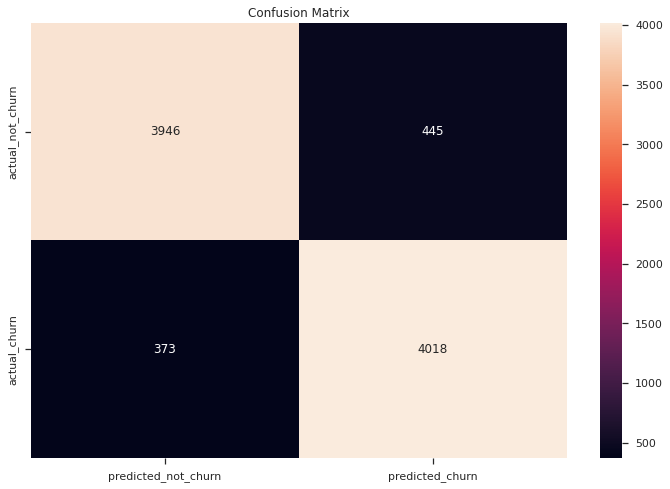

In [201]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(final_model_cm_df, annot=True, fmt='d').set_title('Confusion Matrix')

plt.show()

In [202]:
# Saving the model
pickle.dump(final_model, open('model/model.pkl','wb'))

# 9. Model performance interpretation

## 9.1. Machine learning performance

In [203]:
# calculate model predicted probabilities
y_probas = final_model.predict_proba(x_test)

# get positive class probabilities
y_scores = y_probas[:,1]

# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# current recall from the model
recall_model = final_model_perf['test_recall'][0]

# current precision from the model
precision_model = final_model_perf['test_precision'][0]

# get current precision index
prec_index = np.where(precisions==precision_model)

# get current threshold of the model
threshold_model = thresholds[prec_index]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


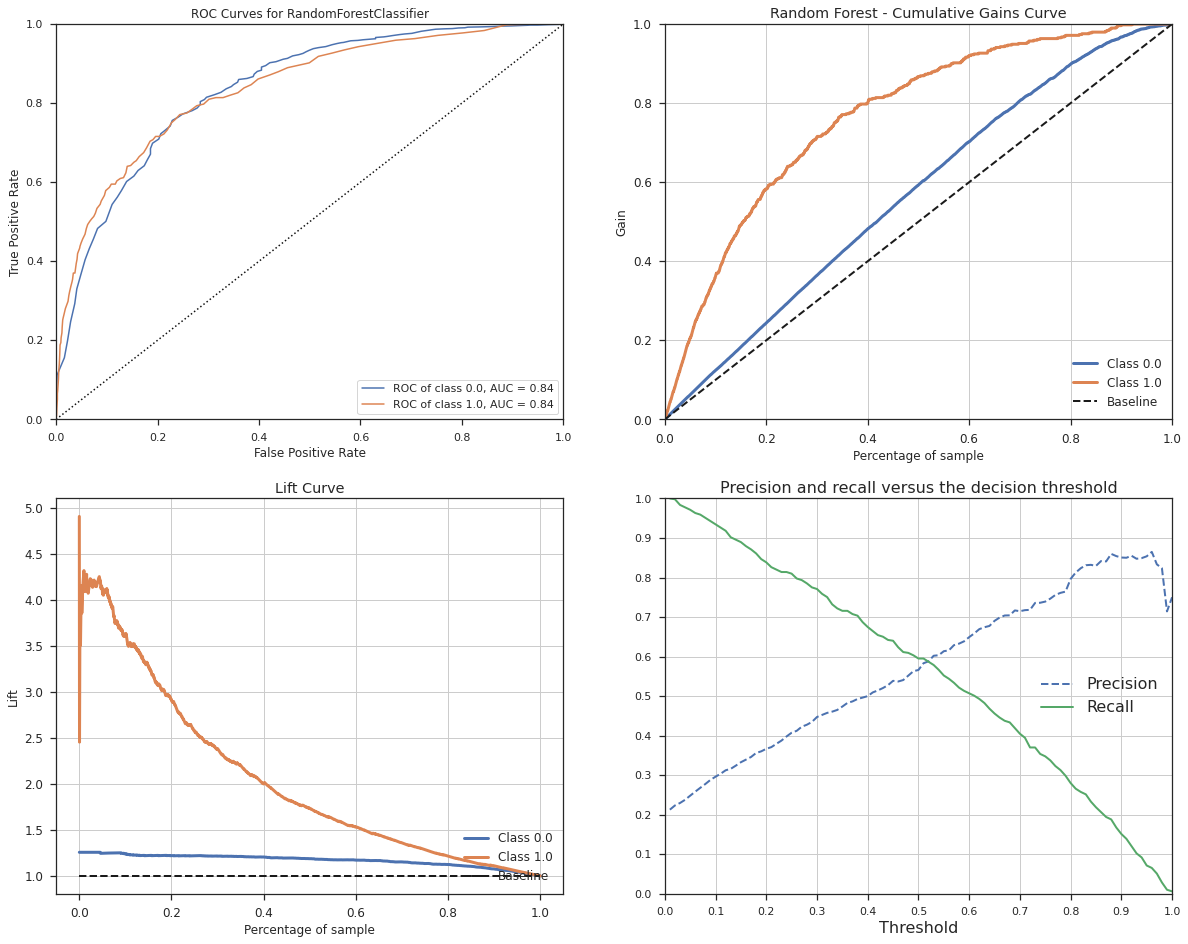

In [204]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 16))


viz = ROCAUC(final_model, iso_f1_curves=True, micro=False, macro=False, ax=ax1)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

#viz = PrecisionRecallCurve(final_model, iso_f1_curves=True, ax=ax2)
#viz.fit(x_train, y_train)
#viz.score(x_test, y_test)
#viz.finalize()

y_proba_rf = final_model.predict_proba(x_test)
plot_cumulative_gain(y_test, y_proba_rf, title='Random Forest - Cumulative Gains Curve', ax=ax2)

 # plot Lift curve
plot_lift_curve(y_test, y_probas, ax=ax3)
plt.legend(loc='center right', fontsize=12)

#Plot precision and recall versus threshold
ax4 = plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
ax4 = plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
ax4 = plt.legend(loc='center right', fontsize=16)
ax4 = plt.xlabel("Threshold", fontsize=16)
ax4 = plt.xticks(np.arange(0, 1.01, step=0.1))
ax4 = plt.yticks(np.arange(0, 1.01, step=0.1))
ax4 = plt.grid(True)
ax4 = plt.axis([0, 1, 0, 1])
ax4 = plt.title('Precision and recall versus the decision threshold', fontsize=16)

**ROC Curve:**
    - The curve shows the model capacity to correctly predict the classification measured by the true positives vs the model classification errors, measured by the true positives.
    - For example, for a false positive rate of 0.20, the true positive rate is around 0.70, which means that the model classified right 70% of total positives as positives and 20% of total negatives as false positives.
    - The closer the curve is from the top-left side, the better, meaning that the model is able to accurately predict a positive as true positive and a negative as true negative.
    
**Cumulative gains curve:**
    - The metric shows the percentage of customers that will churn based on the percentage of the dataset used.
    - For example, with just 20% of the customers, the model is able to capture more than 60% of the clients that are more likely to churn.
    - The closer the curve is from the top-left side, the better, meaning that with a smallest percentage of the samples, the highest percentage of churn customers identified.
    
**Lift curve:**
    - This metric shows the relative probability to classify correctly compared to a random classification (50% churn / 50% not churn). 
    - For example, with 20% of the sample, the probability to correctly classify a customer is 3.0 times higher than a random classification for the churned customers, while just 1.25 times higher for a non churned customer.
    - Higher values for the lift curve indicates that the model has a superior performance than a random classification.


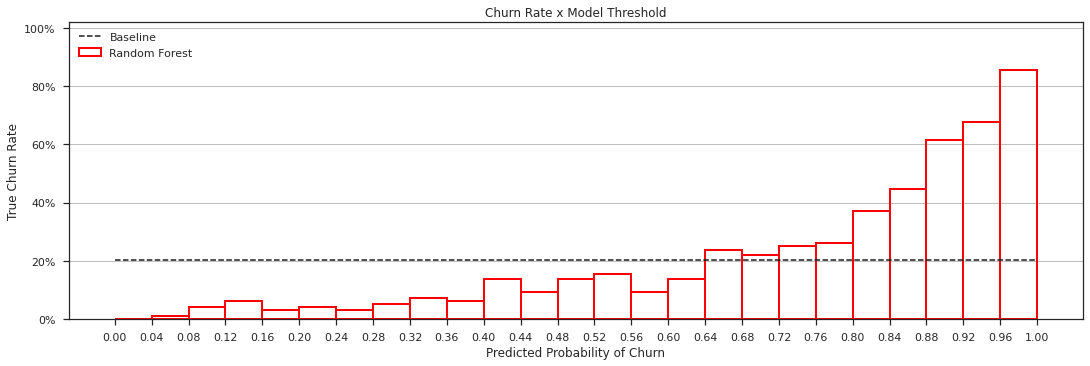

In [205]:
colors = ['red', 'blue', 'black', 'green', 'purple', 'yellow']
rates = []
model_names = []
model_name = 'Random Forest'
step=0.04

total_churn = y_test.sum()
churn_ratio = total_churn / y_test.count()

y_full_proba = final_model.predict_proba(x_test)[:,1]
rates.append(get_rate(y=y_test, y_pred=y_full_proba, step=step))
#lift, gain = get_lift_gain(y_test, y_full_proba, step=step, plot=False)
#lifts.append(lift)
#gains.append(gain)
model_names.append(model_name)

fig = plt.figure(figsize=(40,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
#ax2 = plt.subplot2grid((2, 2), (0, 1))
#ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
#plot_cum_gain(ax2, gains, model_names, step)
#plot_lift(ax3, lifts, model_names, step)

#plt.savefig('images/lift_full.png')
plt.show()

From the results of the test dataset, it is possible to see that customers above 64\% probability of churn, have higher churnrate than average. In this sense, we will consider that customers above 64\% of predicted churn are the customers at risk of churning.

## 9.2. Business performance

At this point we will use the dataset saved for business performance evaluation of the model. First, we will create a class that will do all the work flux from cleaning to getting the predictions of each class. Then, we will evaluate.

- Customers with income higher than average, pays 5% of estimated salary per year in products
- Customers with income at or lower than average pays 3% of the estimated yearly salary in products

In [206]:
class churnPrediction(object):
    
    def __init__(self):
        
        self.path = '/home/pedro/Documents/repos/2-churn-prediction/'
        self.credit_score     = pickle.load(open(self.path + 'parameters/credit_score.pkl','rb'))
        self.age              = pickle.load(open(self.path + 'parameters/age.pkl','rb'))
        self.tenure           = pickle.load(open(self.path + 'parameters/tenure.pkl','rb'))
        self.balance          = pickle.load(open(self.path + 'parameters/balance.pkl','rb'))
        self.num_of_products  = pickle.load(open(self.path + 'parameters/num_of_products.pkl','rb'))
        self.estimated_salary = pickle.load(open(self.path + 'parameters/estimated_salary.pkl','rb'))
        
        self.model            = pickle.load(open(self.path + 'model/model.pkl', 'rb'))
        
    def feature_selection(self, data, features, label='exited'):
        #features=['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited', 'gender', 'geography']
        data_model = data.loc[:, features]
        data_label = data.loc[:, label]
        
        return data_model, data_label
    
    def one_hot_encoding(self, data_model, features):
        
        for col in features:
        
            data_model = pd.get_dummies(data_model, prefix=col, columns=[col])
        
        return data_model
        
        
    def data_scaling(self, data_model):
        
        data_model['credit_score'] = self.credit_score.transform(data_model[['credit_score']].values)
        data_model['age'] = self.age.transform(data_model[['age']].values)
        data_model['tenure'] = self.tenure.transform(data_model[['tenure']].values)
        data_model['balance'] = self.balance.transform(data_model[['balance']].values)
        data_model['num_of_products'] = self.num_of_products.transform(data_model[['num_of_products']].values)
        data_model['estimated_salary'] = self.estimated_salary.transform(data_model[['estimated_salary']].values)
        
        return data_model        
    
    def get_predictions_and_append(self, data, data_model):
        
        y_probas = self.model.predict_proba(data_model)
        
        data['churn_prob'] = y_probas[:,1]
        
        return data

In [207]:
business_df = pd.read_csv('data/processed/evaluation.csv')

evaluation = churnPrediction()

cols_to_select = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'gender', 'geography']

business_x, business_y = evaluation.feature_selection(data=business_df, features=cols_to_select, label='exited')
business_x             = evaluation.one_hot_encoding(business_x, features=['gender', 'geography'])
business_x             = evaluation.data_scaling(business_x)

business_df            = evaluation.get_predictions_and_append(business_df, business_x)

In [208]:
avg_salary = round(business_df['estimated_salary'].mean(), 2)
avg_salary

for customer in range(len(business_df)):
    
    if business_df.loc[customer,'estimated_salary'] <= avg_salary:
        
        business_df.loc[customer,'estimated_revenue'] = round(0.03 * business_df.loc[customer,'estimated_salary'], 2)
        
    else:
        
        business_df.loc[customer,'estimated_revenue'] = round(0.05 * business_df.loc[customer,'estimated_salary'], 2)

print('Total estimated revenue on the data set ${}'.format(round(business_df['estimated_revenue'].sum() ,2)) )
print('Estimated revenue of customers at risk of churn ${}'.format(round(business_df.loc[business_df['churn_prob'] >= 0.64  ,'estimated_revenue'].sum() ,2)) )

Total estimated revenue on the data set $9140263.18
Estimated revenue of customers at risk of churn $1263204.94


From the results, it is possible to see that customers above 0.69 threshold have higher churn rates in comparison to those below the threshold. With this in mind, we will consider as possible churners the customers above that level. In order to evaluate the business performance of the model, we must recover the original test set, before rebalancing the data.

# 10. Optimization

The results of predictions from the model can inform the company the probability that a given client will churn. However, different customers have different probabilities of churn and could brought different values of revenue for the company. With that in mind, the natural question that comes is:

- **Who are the clients that we must direct our efforts first, with a given budget?**

The marketing team gave a budget of promotional coupons to give for customers in churn, in order to recover those customers. It is reasonable to say that customers that could bring different values of revenue for the company, will need different financial effort. For instance, a customer that could brought \\$2000.00 in revenue in a year, may not respond positively if a \\$20.00 coupon is given, however, a customer that could return \\$200.00 will respond positively for this value of coupon. With this in mind, we can bring down our customers in different categories:
- \\$20.00 Coupon for customers under \\$400.00 in expected revenue for the next year.
- \\$50.00 Coupon for customers above \\$400.00 and under \\$1000.00 for the next year.
- \\$100.00 Coupon for customers between \\$1000.00 and \\$5000.00 for the next year.
- \\$250.00 Coupon for customers above $5000.00 in expected return.

This way, we can select customers based in the expected in the mathematical expectation of return from recorevering the revenue from a possible churn and based on a 90\% effectiveness of the coupon:

**Expected return = Coupon effectiveness \* Estimated revenue - Coupon prize**

In [209]:
coupon_effectiveness = 0.90

for customer in range(len(business_df)):
    
    if business_df.loc[customer,'estimated_revenue'] <= 400.0:
        
        business_df.loc[customer,'coupon'] = 20.00
        business_df.loc[customer,'expected_return'] = round(coupon_effectiveness * business_df.loc[customer,'estimated_revenue'] - business_df.loc[customer,'coupon'], 2)
        
    elif business_df.loc[customer,'estimated_revenue'] > 400.0 and business_df.loc[customer,'estimated_revenue'] <= 1000.0:

        business_df.loc[customer,'coupon'] = 50.00
        business_df.loc[customer,'expected_return'] = round(coupon_effectiveness * business_df.loc[customer,'estimated_revenue'] - business_df.loc[customer,'coupon'], 2)
        
    elif business_df.loc[customer,'estimated_revenue'] > 1000.0 and business_df.loc[customer,'estimated_revenue'] <= 5000.0:

        business_df.loc[customer,'coupon'] = 100.00
        business_df.loc[customer,'expected_return'] = round(coupon_effectiveness * business_df.loc[customer,'estimated_revenue'] - business_df.loc[customer,'coupon'], 2)

    elif business_df.loc[customer,'estimated_revenue'] > 5000.0:
        
        business_df.loc[customer,'coupon'] = 250.00
        business_df.loc[customer,'expected_return'] = round(coupon_effectiveness * business_df.loc[customer,'estimated_revenue'] - business_df.loc[customer,'coupon'], 2)

The marketing team provided a initial budget of $10,000.00 in coupons to recover the churning customers. Now, it is possible to use different criteria to optimize the coupon giveaway. We will use two criterias for choosing customers:
- First, we will look for customers with the highest probability of churn,
- Then, if two different customers have the same probability of churn, we will look for the coupon cost and give first for the cheapest coupon value.

With this strategy, we focus on the most likely customers to churn and try to save as mmany customers as possible.

## 10.1. Identifying the customers

In [210]:
customers_at_risk = business_df.loc[business_df['churn_prob'] >= 0.60]

max_customers = customers_at_risk.sort_values(['churn_prob', 'coupon'], ascending=[False, True]).reset_index(drop=True)
customers_list = []
budget = 20000
for customer in range(len(max_customers)):
    
        if budget > max_customers.loc[customer, 'coupon']:

            budget -= max_customers.loc[customer, 'coupon']
            customers_list.append(max_customers.loc[customer, 'customer_id'])

        elif budget == max_customers.loc[customer, 'coupon']:

            budget = 0
            customers_list.append(max_customers.loc[customer, 'customer_id'])
            
print('Remaining budget: ${} \nTotal customers included at the coupon giveaway: {}'.format(budget, len(customers_list)))

Remaining budget: $0 
Total customers included at the coupon giveaway: 129


## 10.2. Analyzing the results

### 10.2.1. By number of customers and churnrate

In [211]:
selected_customers = max_customers[max_customers['customer_id'].isin(customers_list)]
print('Total analyzed customers from the dataset:                        {}'.format(business_df['exited'].count()))
print('Total churned customers from the dataset:                         {}'.format(business_df['exited'].sum()))
print('Total customers considered at risk of churning:                   {}'.format(customers_at_risk['exited'].count()))
print('Total churned customers that were considered at risk of churning: {}'.format(customers_at_risk['exited'].sum()))
print('Total that received a coupon:                                     {}'.format(selected_customers['exited'].count()))
print('Total recovered customers from the coupon giveaway:               {}'.format(selected_customers['exited'].sum()))

Total analyzed customers from the dataset:                        2000
Total churned customers from the dataset:                         407
Total customers considered at risk of churning:                   312
Total churned customers that were considered at risk of churning: 205
Total that received a coupon:                                     129
Total recovered customers from the coupon giveaway:               109


From the previous results, it is possible to see that from the initial 2000 customers (~ 20\% churnrate), we identified initially 312 customers with a significant higher risk of churning, where 205 actually churned (~ 65\% churnrate). With this small group of 312 customers, a small marketing campaign with a budget of $10,000.00, gave coupons for 129 customers, where 109 actually churned (~85\% churnrate). This show that with a small budget and the model developed, the company were able to recover up to 25\% of the churned customers.

### 10.2.2. By financial results

In [212]:
print('Total estimated revenue from the dataset:                       ${}'.format(round( business_df['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue lost due to churn from the dataset:     ${}'.format(round( business_df.loc[business_df['exited'] == 1, 'estimated_revenue'].sum(), 2)) )
print('Total estimated revenue from customers identified as at risk:   ${}'.format(round( customers_at_risk['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue lost due to churn of customers at risk: ${}'.format(round( customers_at_risk.loc[customers_at_risk['exited'] == 1, 'estimated_revenue'].sum(), 2)) )
print('Total estimated revenue of customers with coupon:               ${}'.format(round( selected_customers['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue recovered:                              ${}'.format(round( selected_customers.loc[selected_customers['exited'] == 1, 'estimated_revenue'].sum(), 2)) )

Total estimated revenue from the dataset:                       $9140263.18
Total estimated revenue lost due to churn from the dataset:     $1785291.91
Total estimated revenue from customers identified as at risk:   $1445179.91
Total estimated revenue lost due to churn of customers at risk: $951629.1
Total estimated revenue of customers with coupon:               $542877.01
Total estimated revenue recovered:                              $459258.16


From the results it is possible to see that about \\$1.78M revenue is lost due to churning of customers, which represents about 19\% of total revenue. From the initial customers, we identified a total of \\$1.44M of potential revenue lost of churned clients. With the coupon marketing campaing, the company was able to recover \\$0.460M of revenue with a budget of only $0.02M, which represents a **2300% return on invested capital (ROIC)**. This represents a great investment for the company and it is possible to see other scenarios with a expanded marketing campaign.

### 10.2.3. With a expanded campaing

In [213]:
customers_at_risk = business_df.loc[business_df['churn_prob'] >= 0.60]

max_customers = customers_at_risk.sort_values(['churn_prob', 'coupon'], ascending=[False, True]).reset_index(drop=True)
customers_list = []
budget = 40000
for customer in range(len(max_customers)):
    
        if budget > max_customers.loc[customer, 'coupon']:

            budget -= max_customers.loc[customer, 'coupon']
            customers_list.append(max_customers.loc[customer, 'customer_id'])

        elif budget == max_customers.loc[customer, 'coupon']:

            budget = 0
            customers_list.append(max_customers.loc[customer, 'customer_id'])
            
print('Remaining budget: ${} \nTotal customers included at the coupon giveaway: {}'.format(budget, len(customers_list)))

Remaining budget: $0 
Total customers included at the coupon giveaway: 250


In [214]:
selected_customers = max_customers[max_customers['customer_id'].isin(customers_list)]

print('Total analyzed customers from the dataset:                        {}'.format(business_df['exited'].count()))
print('Total churned customers from the dataset:                         {}'.format(business_df['exited'].sum()))
print('Total customers considered at risk of churning:                   {}'.format(customers_at_risk['exited'].count()))
print('Total churned customers that were considered at risk of churning: {}'.format(customers_at_risk['exited'].sum()))
print('Total that received a coupon:                                     {}'.format(selected_customers['exited'].count()))
print('Total recovered customers from the coupon giveaway:               {}'.format(selected_customers['exited'].sum()))

print('\nTotal estimated revenue from the dataset:                       ${}'.format(round( business_df['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue lost due to churn from the dataset:     ${}'.format(round( business_df.loc[business_df['exited'] == 1, 'estimated_revenue'].sum(), 2)) )
print('Total estimated revenue from customers identified as at risk:   ${}'.format(round( customers_at_risk['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue lost due to churn of customers at risk: ${}'.format(round( customers_at_risk.loc[customers_at_risk['exited'] == 1, 'estimated_revenue'].sum(), 2)) )
print('Total estimated revenue of customers with coupon:               ${}'.format(round( selected_customers['estimated_revenue'].sum(), 2)) )
print('Total estimated revenue recovered:                              ${}'.format(round( selected_customers.loc[selected_customers['exited'] == 1, 'estimated_revenue'].sum(), 2)) )

Total analyzed customers from the dataset:                        2000
Total churned customers from the dataset:                         407
Total customers considered at risk of churning:                   312
Total churned customers that were considered at risk of churning: 205
Total that received a coupon:                                     250
Total recovered customers from the coupon giveaway:               179

Total estimated revenue from the dataset:                       $9140263.18
Total estimated revenue lost due to churn from the dataset:     $1785291.91
Total estimated revenue from customers identified as at risk:   $1445179.91
Total estimated revenue lost due to churn of customers at risk: $951629.1
Total estimated revenue of customers with coupon:               $1103455.69
Total estimated revenue recovered:                              $801384.58


With a increase of budget from \\$20,000 to \\$40,000, it was possible to increse the number of coupons given to different customers from 129 to 250, where recovered churned customers increases from 109 to 179. Also, the recovered revenue lost from churning increased from about \\$0.460M to \\$0.800M (revenue recovered from total lost increased from 25\% to  45\%). **However, the return over invested capital had a small decrease from 2300\% to 2000\%, which still justifies the investment.**